Homework 2

Christopher Beam

800927396

# Problem 1

### Part 1

In [1]:
# Required imports
import torch
from PIL import Image
from torchvision import transforms
from torchvision import datasets
%matplotlib inline
from matplotlib import pyplot as plt
import torch.optim as optim
import pandas as pd
import numpy as np
import torch.nn as nn
import time
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name())
    print("Memory Usage:")
    print("\tAllocated:", round(torch.cuda.memory_allocated()/1024**3,1), "GB")
    print("\tCached:", round(torch.cuda.memory_reserved()/1024**3,1), "GB")
#device = torch.device('cpu')

Using device:  cuda

NVIDIA GeForce GTX 1070
Memory Usage:
	Allocated: 0.0 GB
	Cached: 0.0 GB


In [3]:
housing = pd.DataFrame(pd.read_csv("../Data/Homework2/Housing.csv"))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# Get the area, bedrooms, bathrooms, stories, parking, and price
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
housing = housing[num_vars] 
housing.head() 

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [5]:
split = int(len(housing)*0.8)
# Convert Panda to tensor
ht_t = housing.iloc[:split,:5]
hp_t = housing.iloc[:split,5]
ht_t = torch.from_numpy(ht_t.to_numpy())
hp_t = torch.from_numpy(hp_t.to_numpy())
ht_t = ht_t.float()
hp_t = hp_t.float()

ht_v = housing.iloc[split:,:5]
hp_v = housing.iloc[split:,5]
ht_v = torch.from_numpy(ht_v.to_numpy())
hp_v = torch.from_numpy(hp_v.to_numpy())
ht_v = ht_v.float()
hp_v = hp_v.float()

In [6]:
# Normalize input and output
ht_tn = ht_t
for idx in range(5):
    ht_tn[:,idx] = ht_t[:,idx]/ht_t[:,idx].max()
    #ht_tn[:,idx] = (ht_t[:,idx] - ht_t.mean())/ht_t.std()
hp_tn = hp_t/hp_t.max()
#hp_tn = (hp_t-hp_t.mean())/hp_t.std()

ht_vn = ht_v
for idx in range(5):
    ht_vn[:,idx] = ht_v[:,idx]/ht_v[:,idx].max()
    #ht_vn[:,idx] = (ht_v[:,idx] - ht_v.mean())/ht_v.std()
hp_vn = hp_v/hp_v.max()
#hp_vn = (hp_v-hp_v.mean())/hp_v.std()

In [7]:
def training_loopH(n_epochs, optimizer, model, loss_fn, ht, htp, hv, hvp):
    temp_t = []
    temp_v = []
    tic = time.time()
    for epoch in range(1, n_epochs + 1):
        cost_p = model(ht)
        loss_t = loss_fn(cost_p, htp)
        
        with torch.no_grad():
            cost_v = model(hv)
            loss_v = loss_fn(cost_v, hvp)
            #loss_v = 1-(torch.abs(hvp-cost_v).mean()/hvp.mean())
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        #print("Epoch %d, Train Loss %f, Val Loss %f" % (epoch, float(loss_t), float(loss_v)))
        temp_t.append(float(loss_t))
        temp_v.append(float(loss_v))
    print("Time to complete training: %f" % float(time.time()-tic))
    fig = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), temp_t, 'ro')
    fig2 = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Validation MSE")
    plt.plot(range(1,n_epochs+1), temp_v,'bo')

Time to complete training: 0.078974


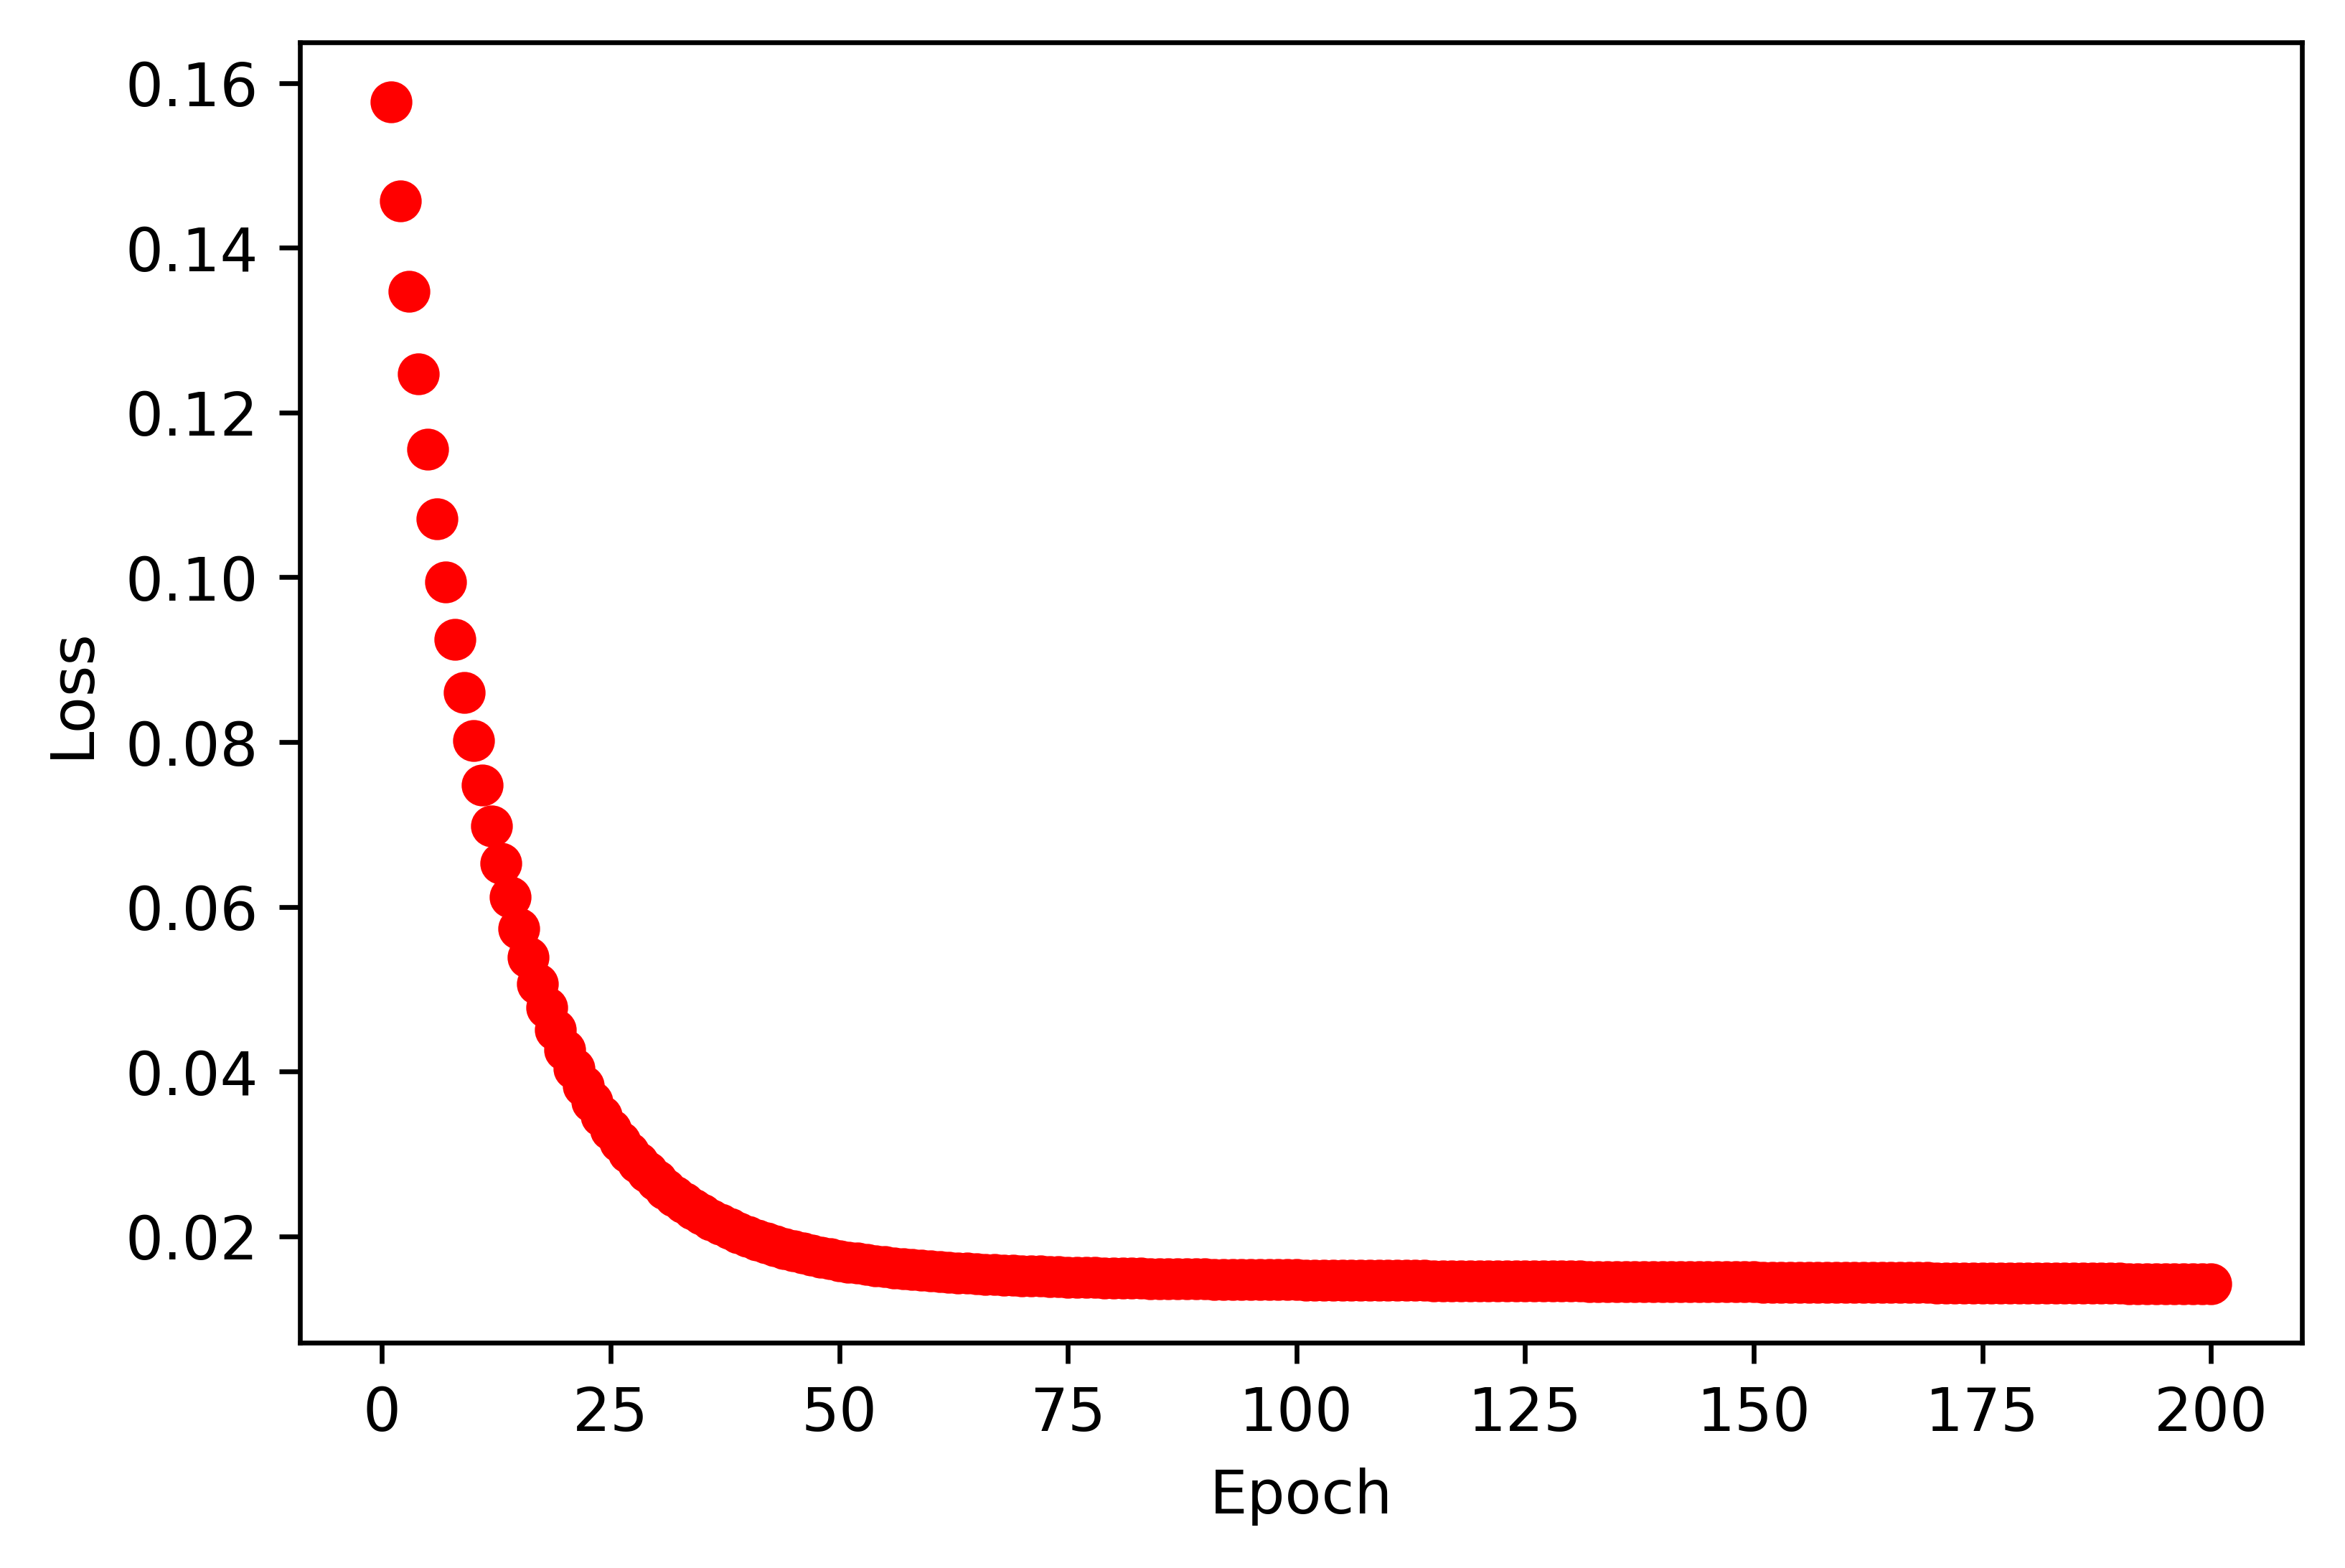

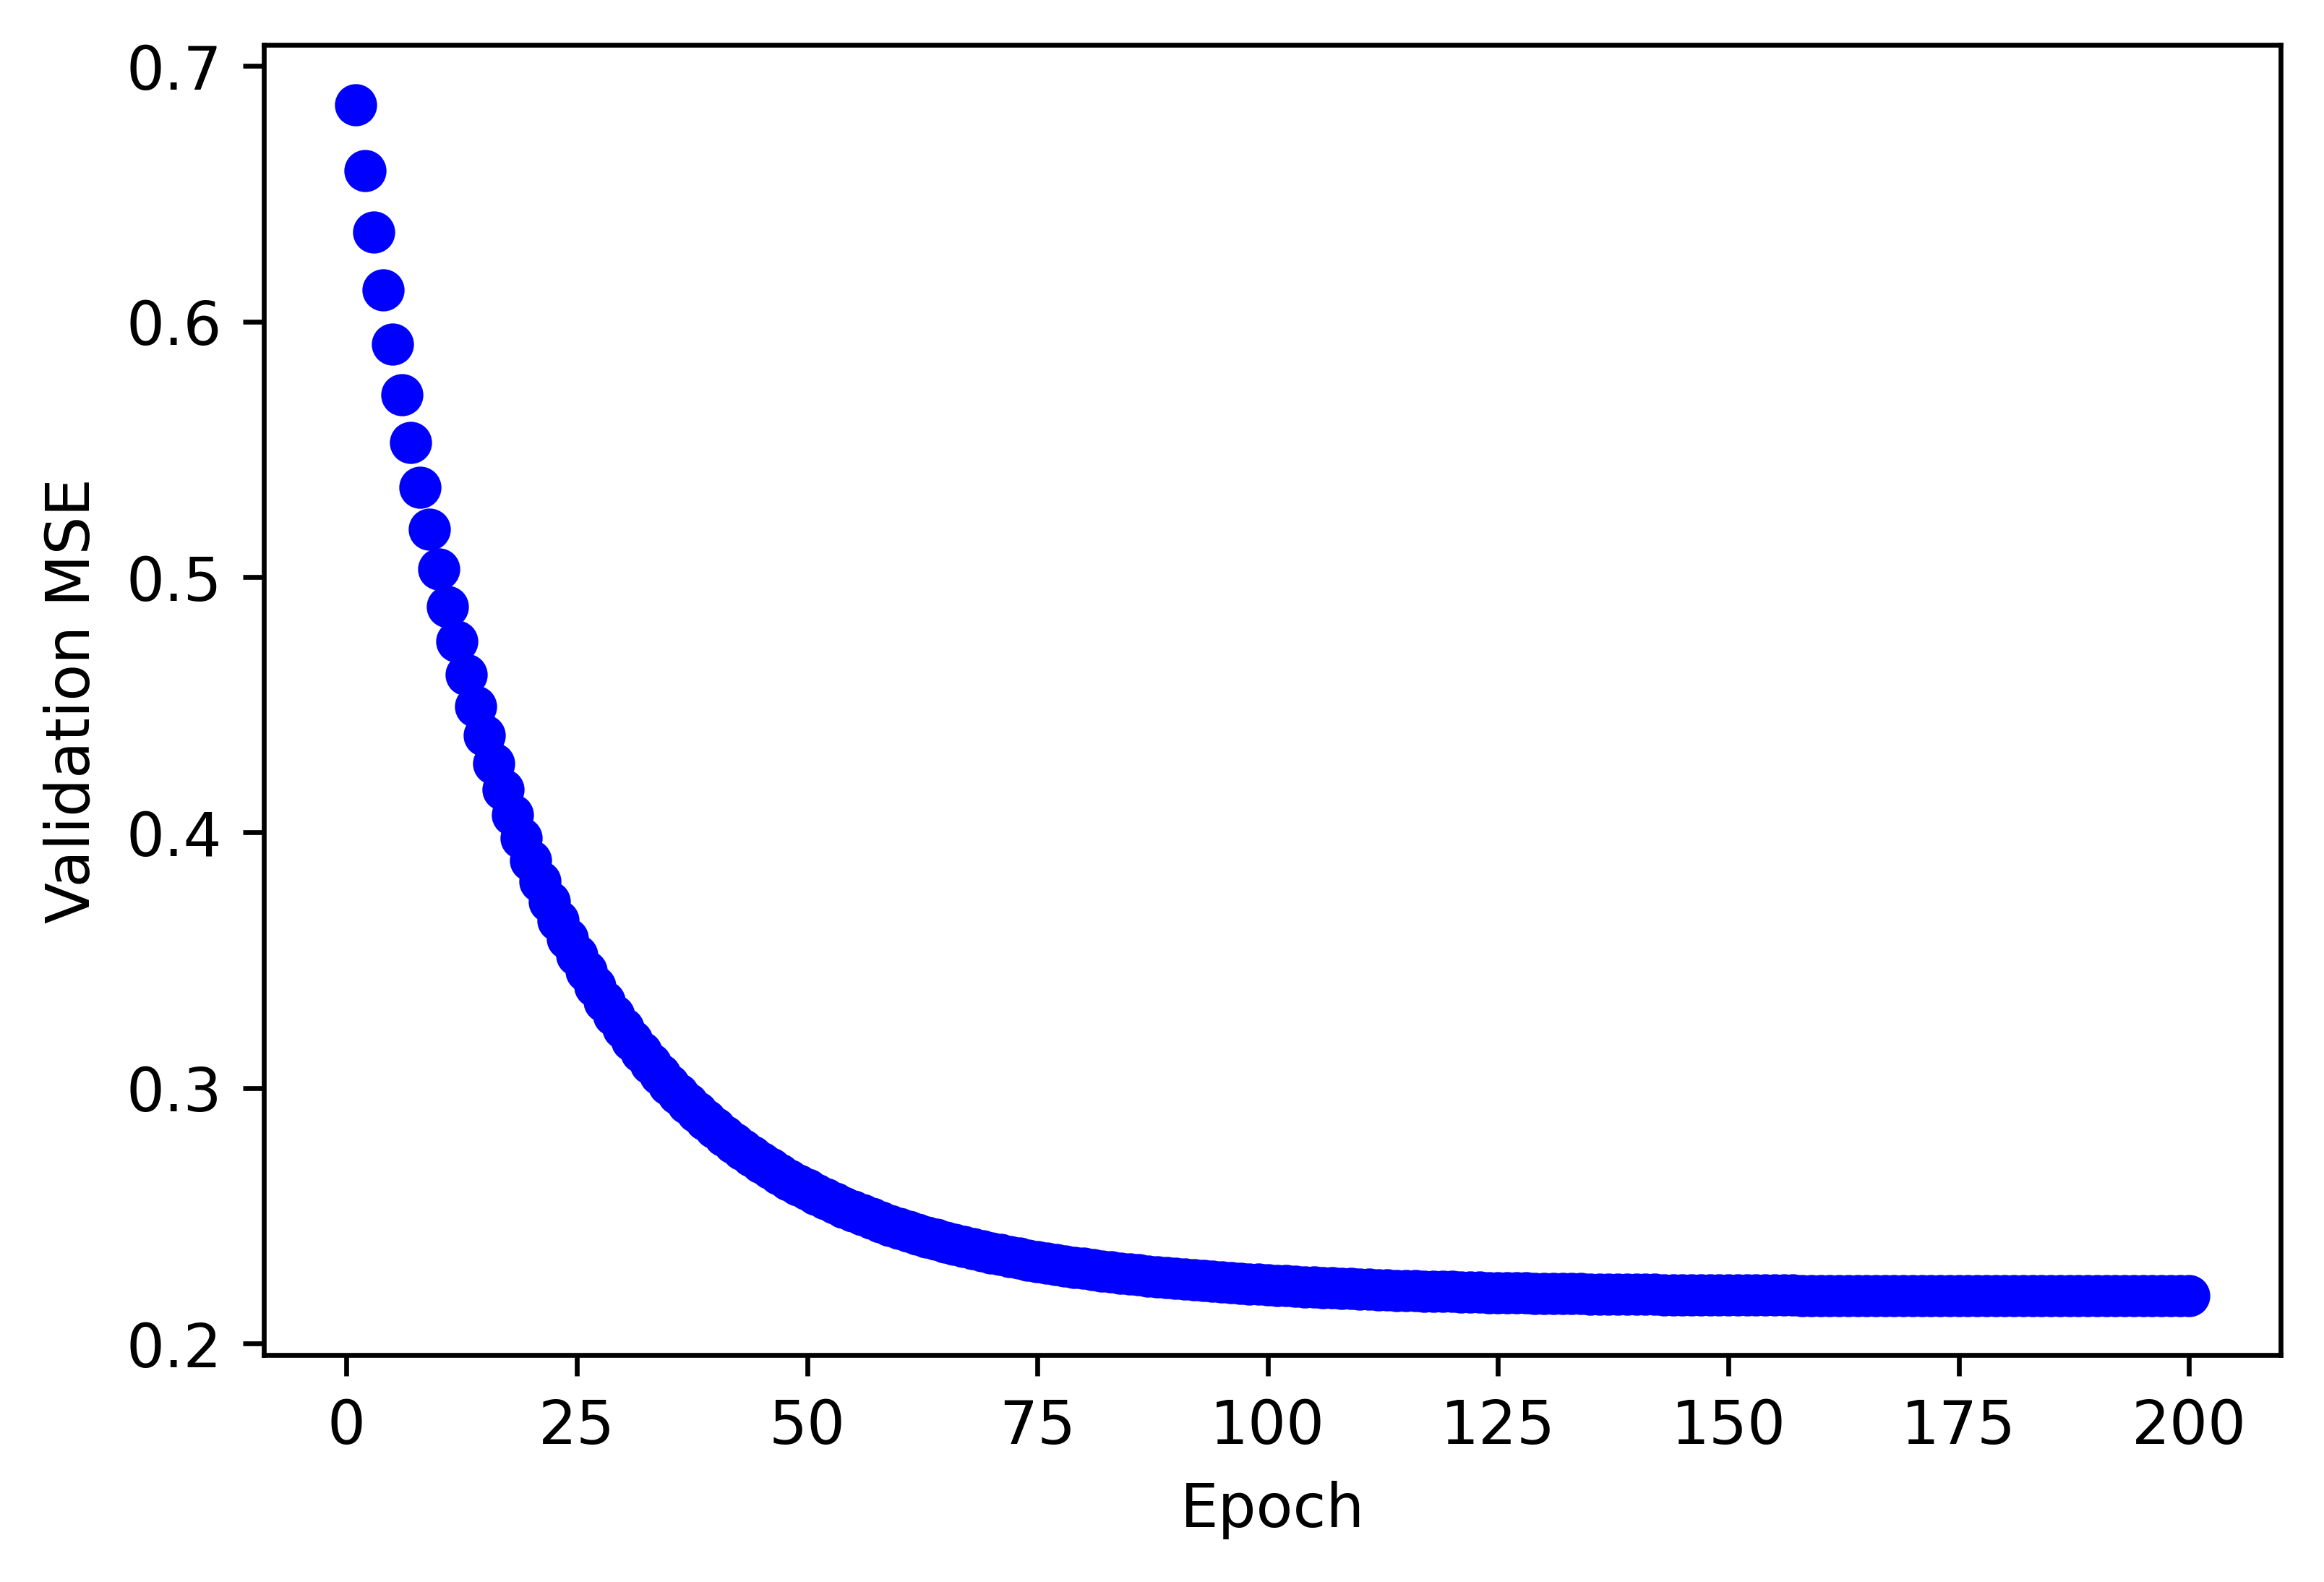

In [8]:
modelH = nn.Sequential(
    nn.Linear(5,8),
    nn.Tanh(),
    nn.Linear(8,1)
)

optimizerH = optim.SGD(
    modelH.parameters(),
    lr=1e-2
)

training_loopH(
    n_epochs=200,
    optimizer=optimizerH,
    model=modelH,
    loss_fn = nn.MSELoss(),
    ht=ht_tn,
    htp=hp_tn.unsqueeze(1),
    hv=ht_vn,
    hvp=hp_vn.unsqueeze(1)
)

### Part 2

Time to complete training: 0.123006


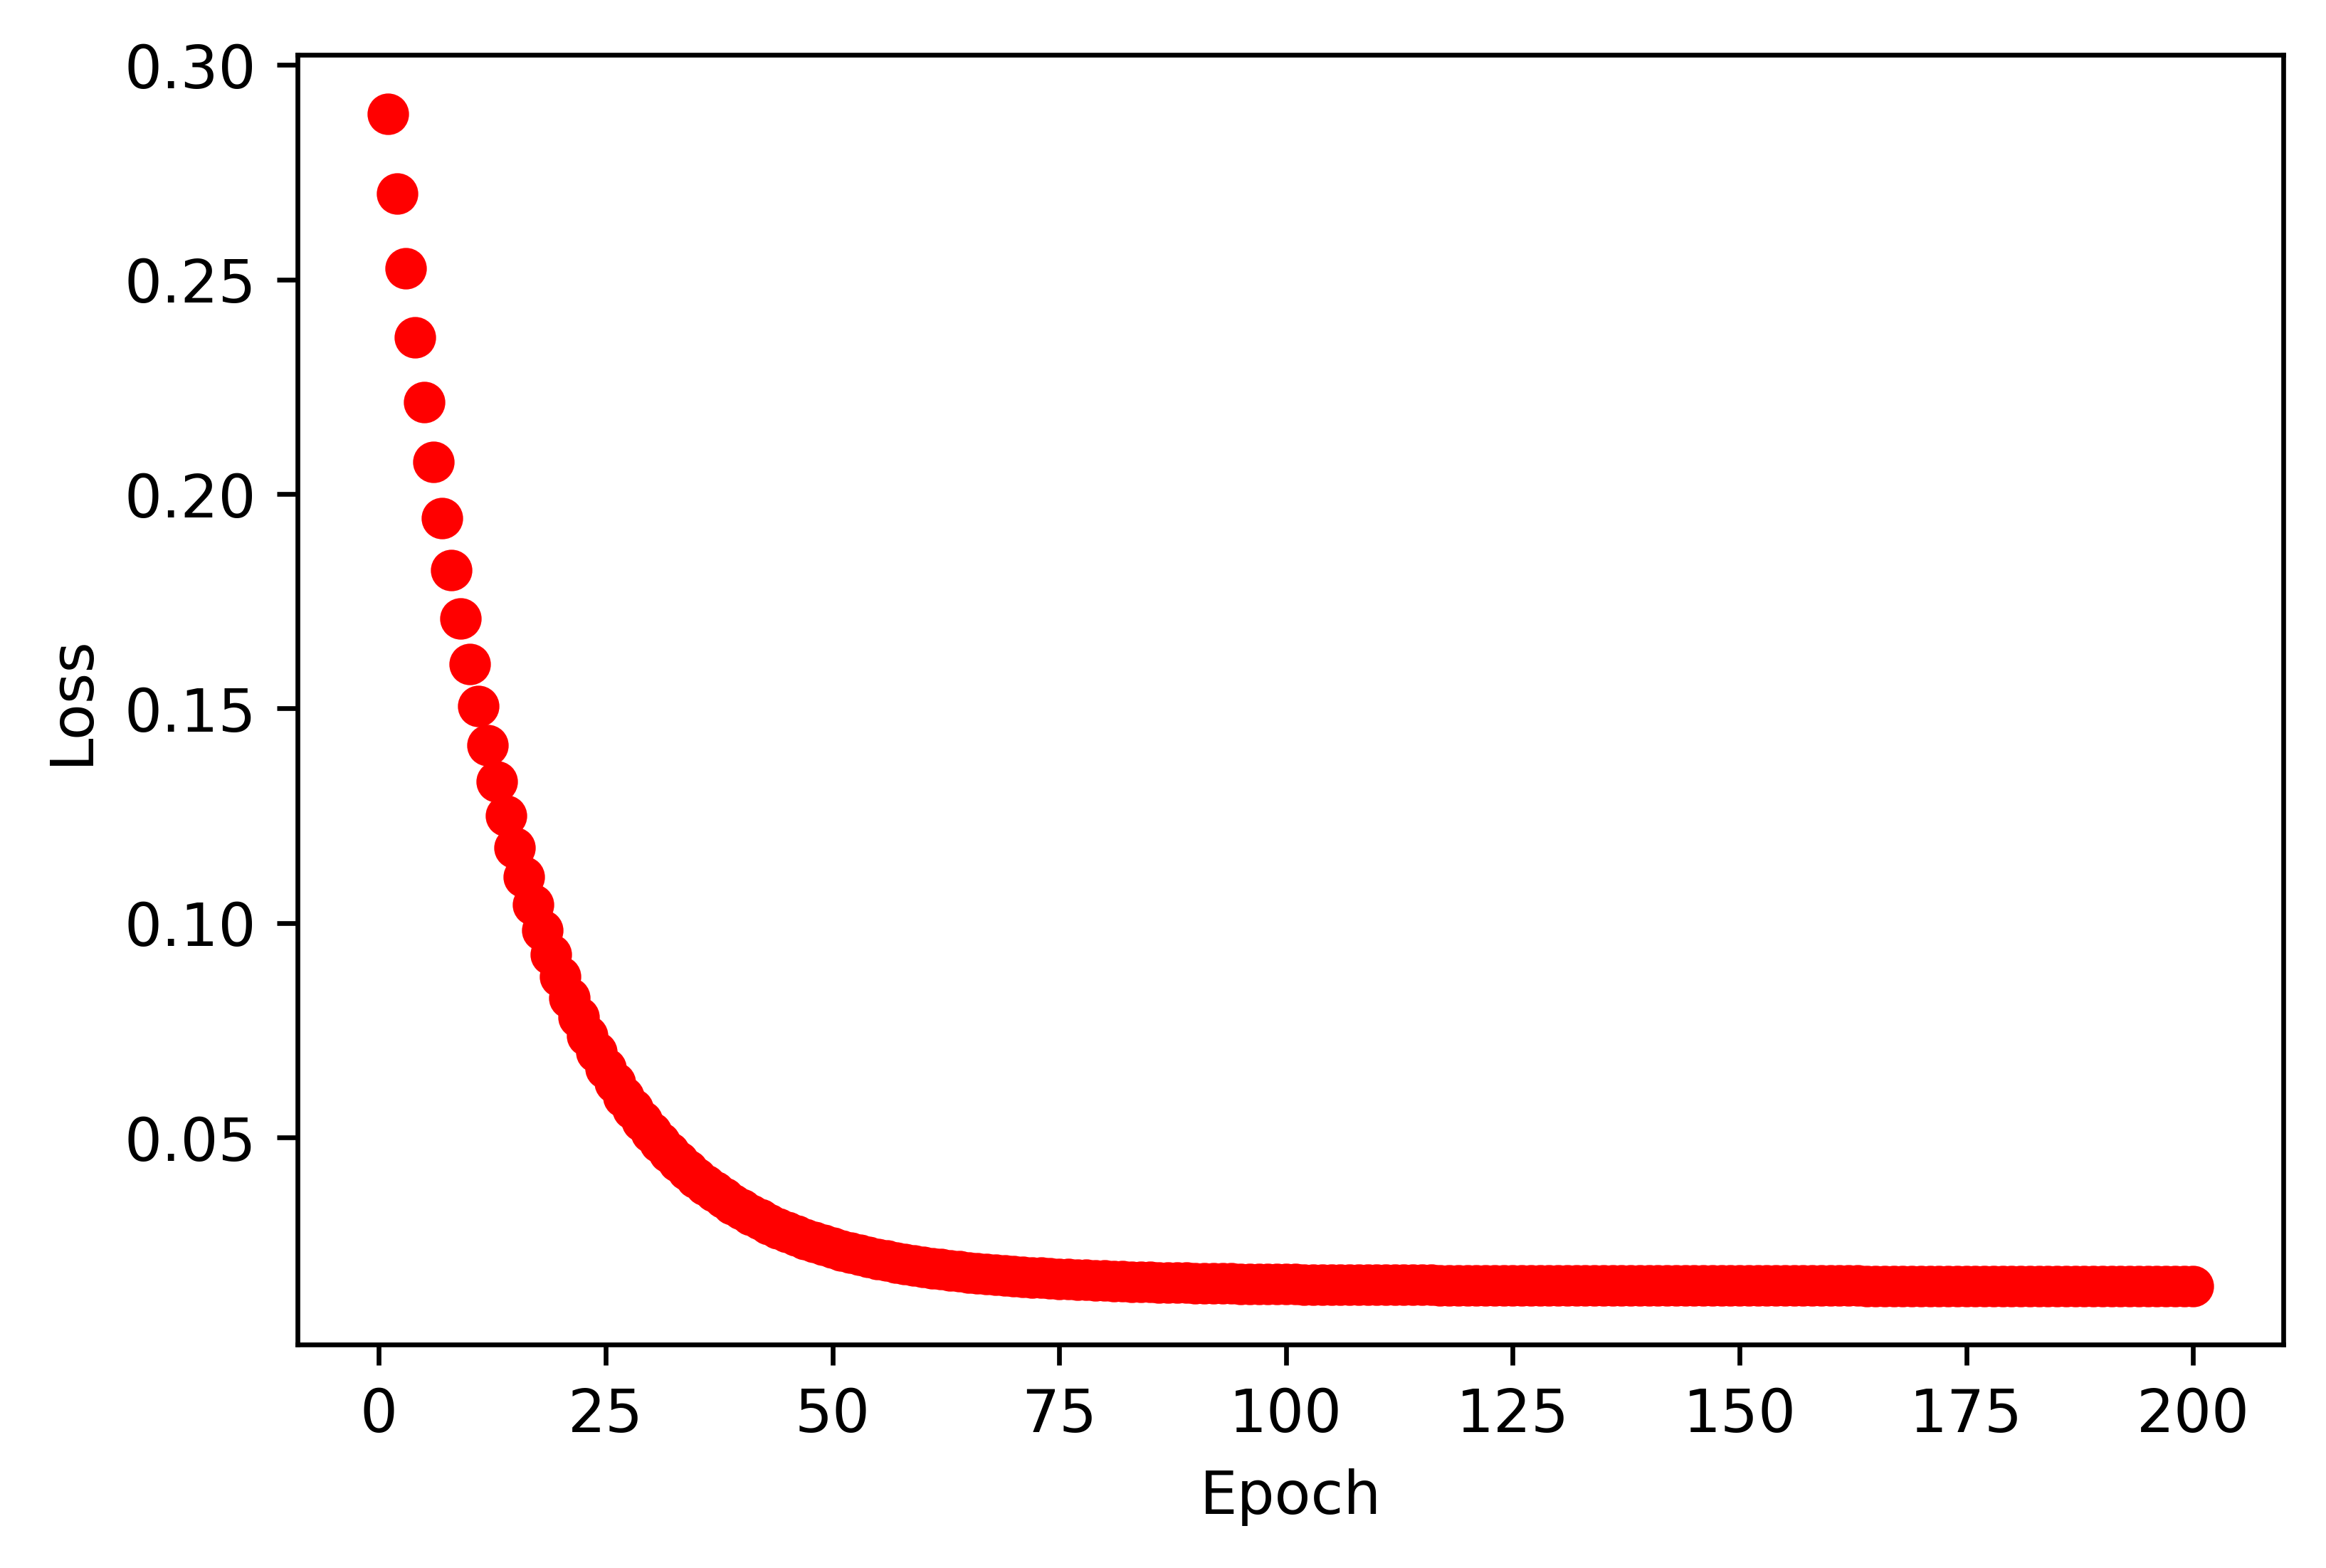

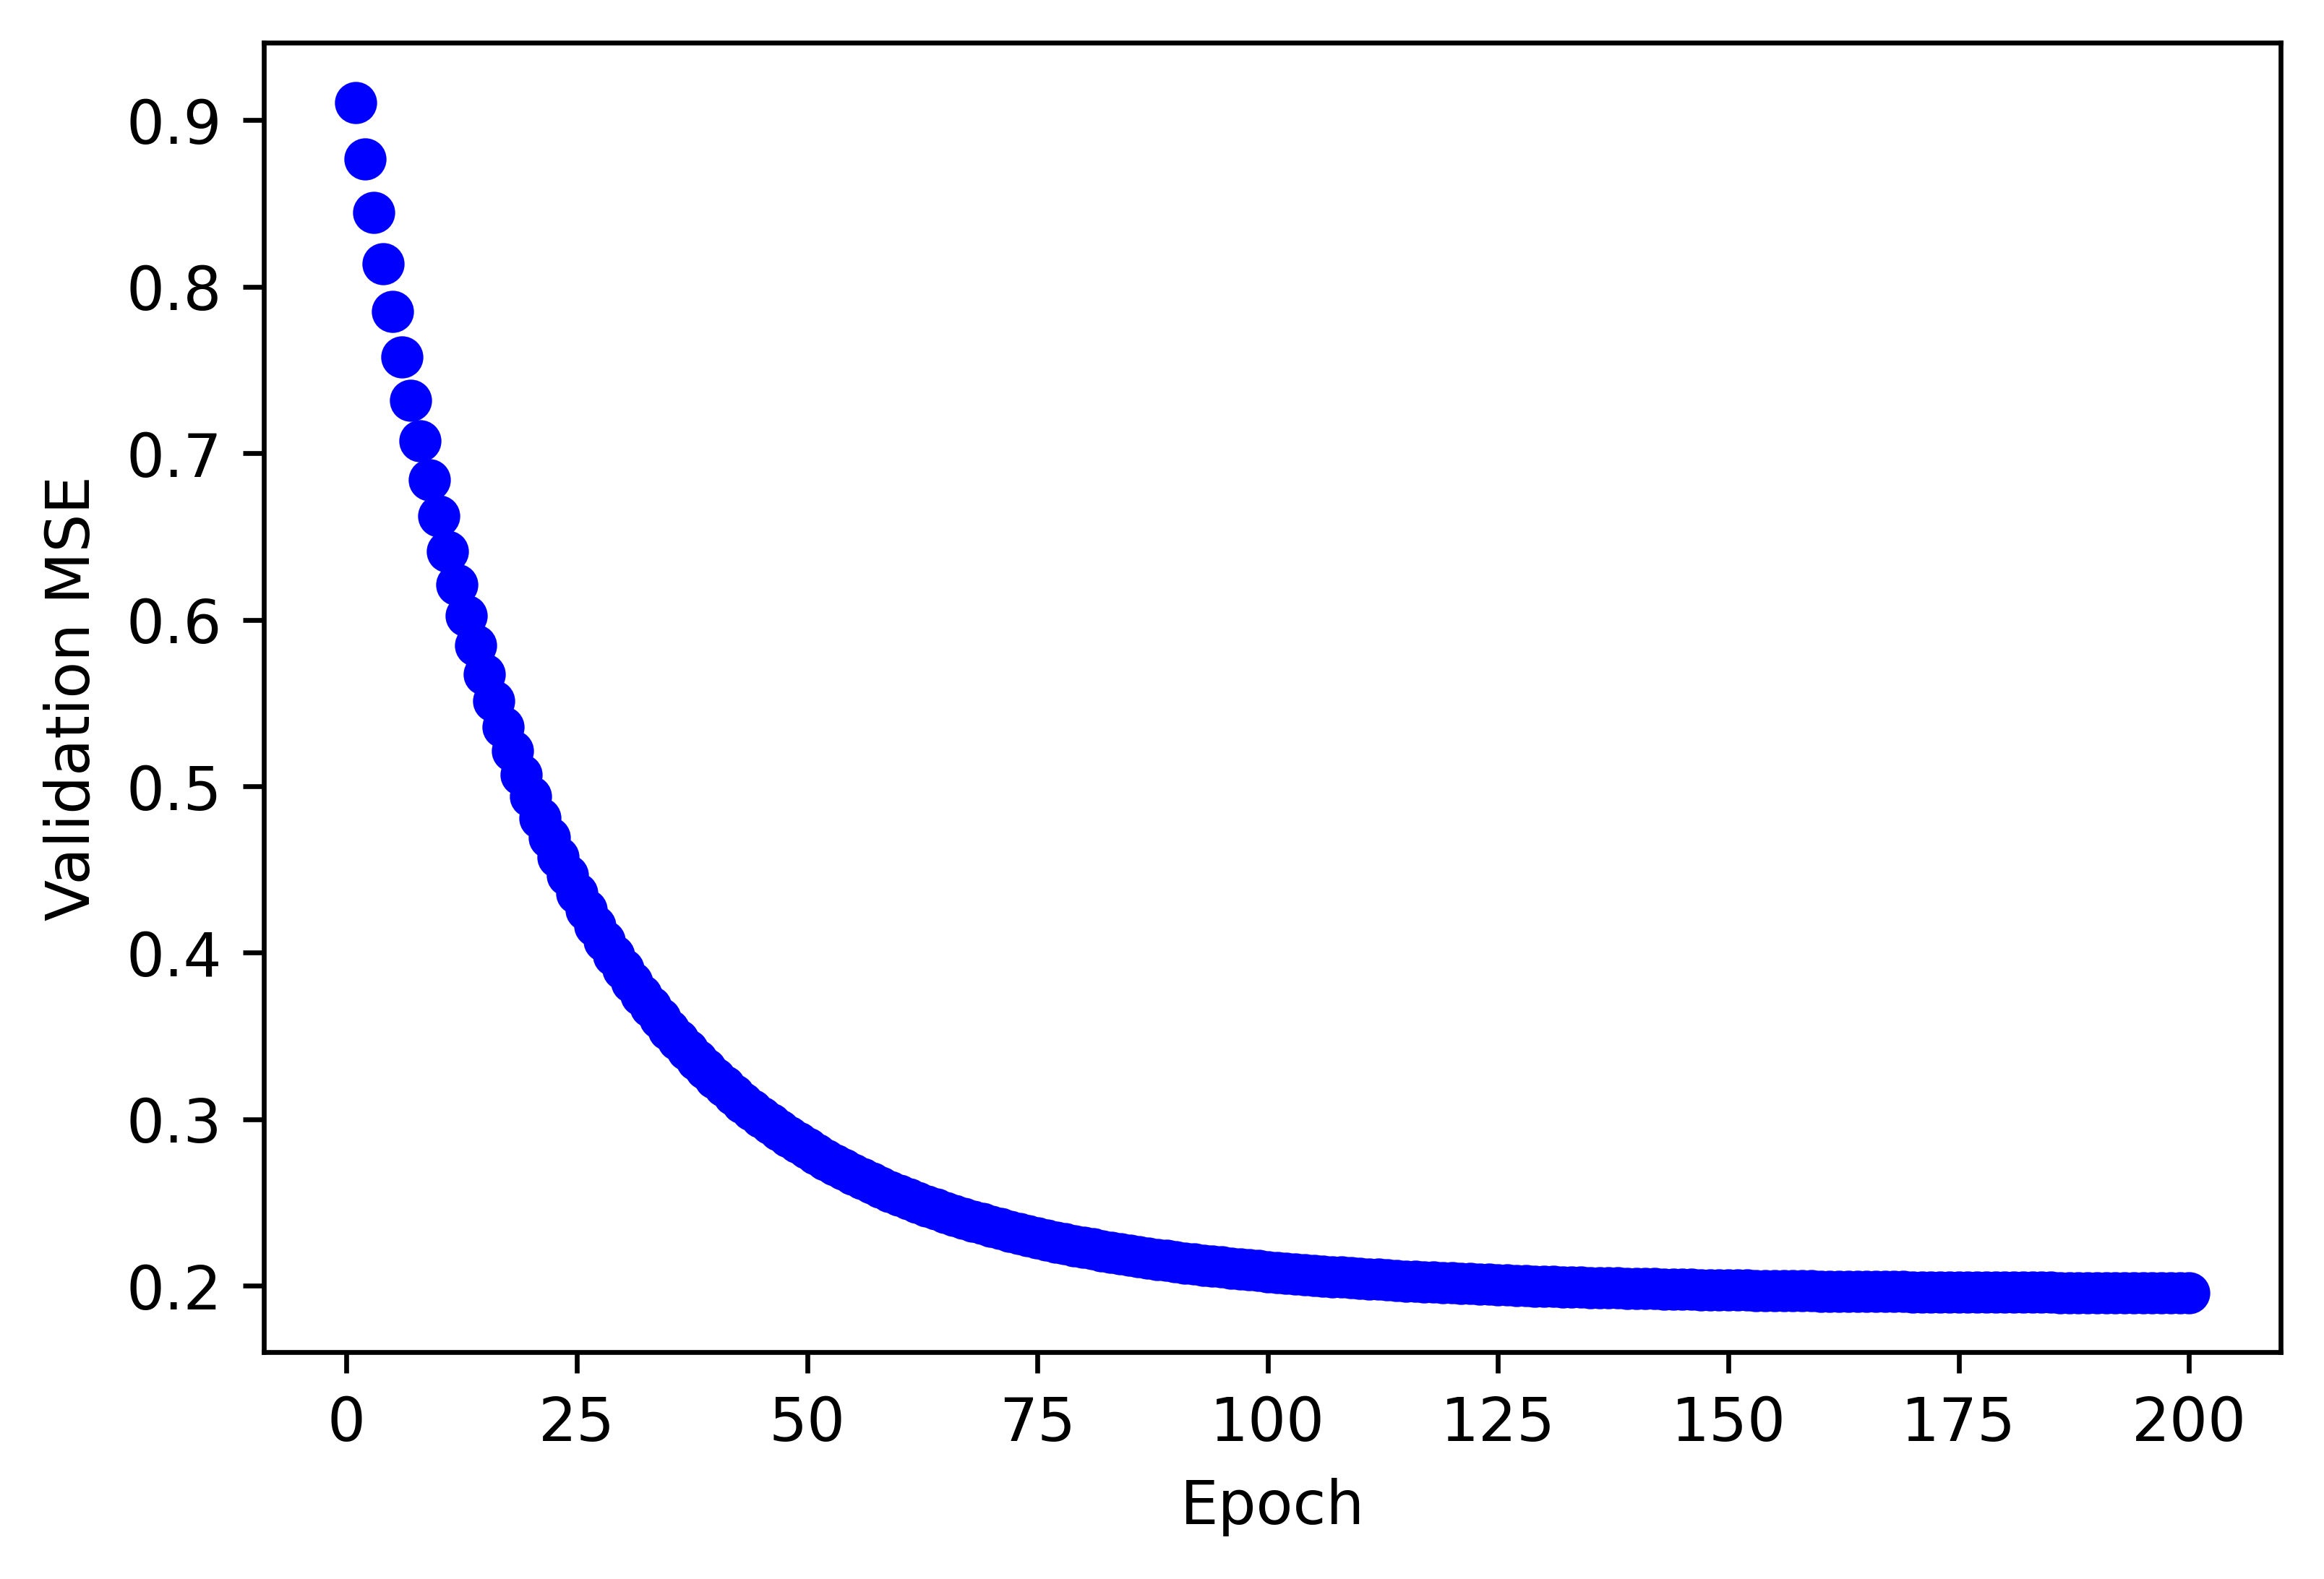

In [9]:
modelH2 = nn.Sequential(
    nn.Linear(5,8),
    nn.Tanh(),
    nn.Linear(8,4),
    nn.Tanh(),
    nn.Linear(4,2),
    nn.Tanh(),
    nn.Linear(2,1)
)

optimizerH2 = optim.SGD(
    modelH2.parameters(),
    lr=1e-2
)

training_loopH(
    n_epochs=200,
    optimizer=optimizerH2,
    model=modelH2,
    loss_fn = nn.MSELoss(),
    ht=ht_tn,
    htp=hp_tn.unsqueeze(1),
    hv=ht_vn,
    hvp=hp_vn.unsqueeze(1)
)

# Problem 2

### Part 1

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
data_path = '../Data/Homework2/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [11]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs_val = torch.stack([img_t for img_t,_ in cifar10_val], dim=3)
train_mean = imgs.view(3,-1).mean(dim=1)
train_std = imgs.view(3,-1).std(dim=1)
val_mean = imgs_val.view(3,-1).mean(dim=1)
val_std = imgs_val.view(3,-1).std(dim=1)

In [12]:
norm_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean,train_std)
]))
norm_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(val_mean,val_std)
]))

In [13]:
train_loader = torch.utils.data.DataLoader(norm_cifar10, batch_size=1000, shuffle=True)
val_loader = torch.utils.data.DataLoader(norm_cifar10_val, batch_size=1000, shuffle=True)

In [14]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_load, val_load):
    temp_t = []
    temp_v = []
    tic = time.time()
    for epoch in range(1, n_epochs + 1):
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
        
            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size,-1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
        
                batch_size = imgs.shape[0]
                outputs = model(imgs.view(batch_size,-1))
                _, predicted = torch.max(outputs,dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        
        if epoch % 10 == 0:
            print("Epoch %d, Train Loss: %f, Val Accuracy: %f" % (epoch, float(loss), float(correct/total)))
        temp_t.append(float(loss))
        temp_v.append(float(correct/total))
    print("Time to complete training: %f" % float(time.time()-tic))
    fig = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(range(1,n_epochs+1), temp_t, 'ro')
    fig2 = plt.figure(dpi=600)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(range(1,n_epochs+1), temp_v,'bo')

Epoch 10, Train Loss: 1.726674, Val Accuracy: 0.404600
Epoch 20, Train Loss: 1.736355, Val Accuracy: 0.420500
Epoch 30, Train Loss: 1.618338, Val Accuracy: 0.431300
Epoch 40, Train Loss: 1.597028, Val Accuracy: 0.436600
Epoch 50, Train Loss: 1.572947, Val Accuracy: 0.446900
Epoch 60, Train Loss: 1.537423, Val Accuracy: 0.450400
Epoch 70, Train Loss: 1.495255, Val Accuracy: 0.457000
Epoch 80, Train Loss: 1.485376, Val Accuracy: 0.461800
Epoch 90, Train Loss: 1.416507, Val Accuracy: 0.465600
Epoch 100, Train Loss: 1.441943, Val Accuracy: 0.471200
Epoch 110, Train Loss: 1.388025, Val Accuracy: 0.474700
Epoch 120, Train Loss: 1.344957, Val Accuracy: 0.478900
Epoch 130, Train Loss: 1.310756, Val Accuracy: 0.481600
Epoch 140, Train Loss: 1.219319, Val Accuracy: 0.484200
Epoch 150, Train Loss: 1.238972, Val Accuracy: 0.485000
Epoch 160, Train Loss: 1.229063, Val Accuracy: 0.488500
Epoch 170, Train Loss: 1.245791, Val Accuracy: 0.489400
Epoch 180, Train Loss: 1.167827, Val Accuracy: 0.493500
E

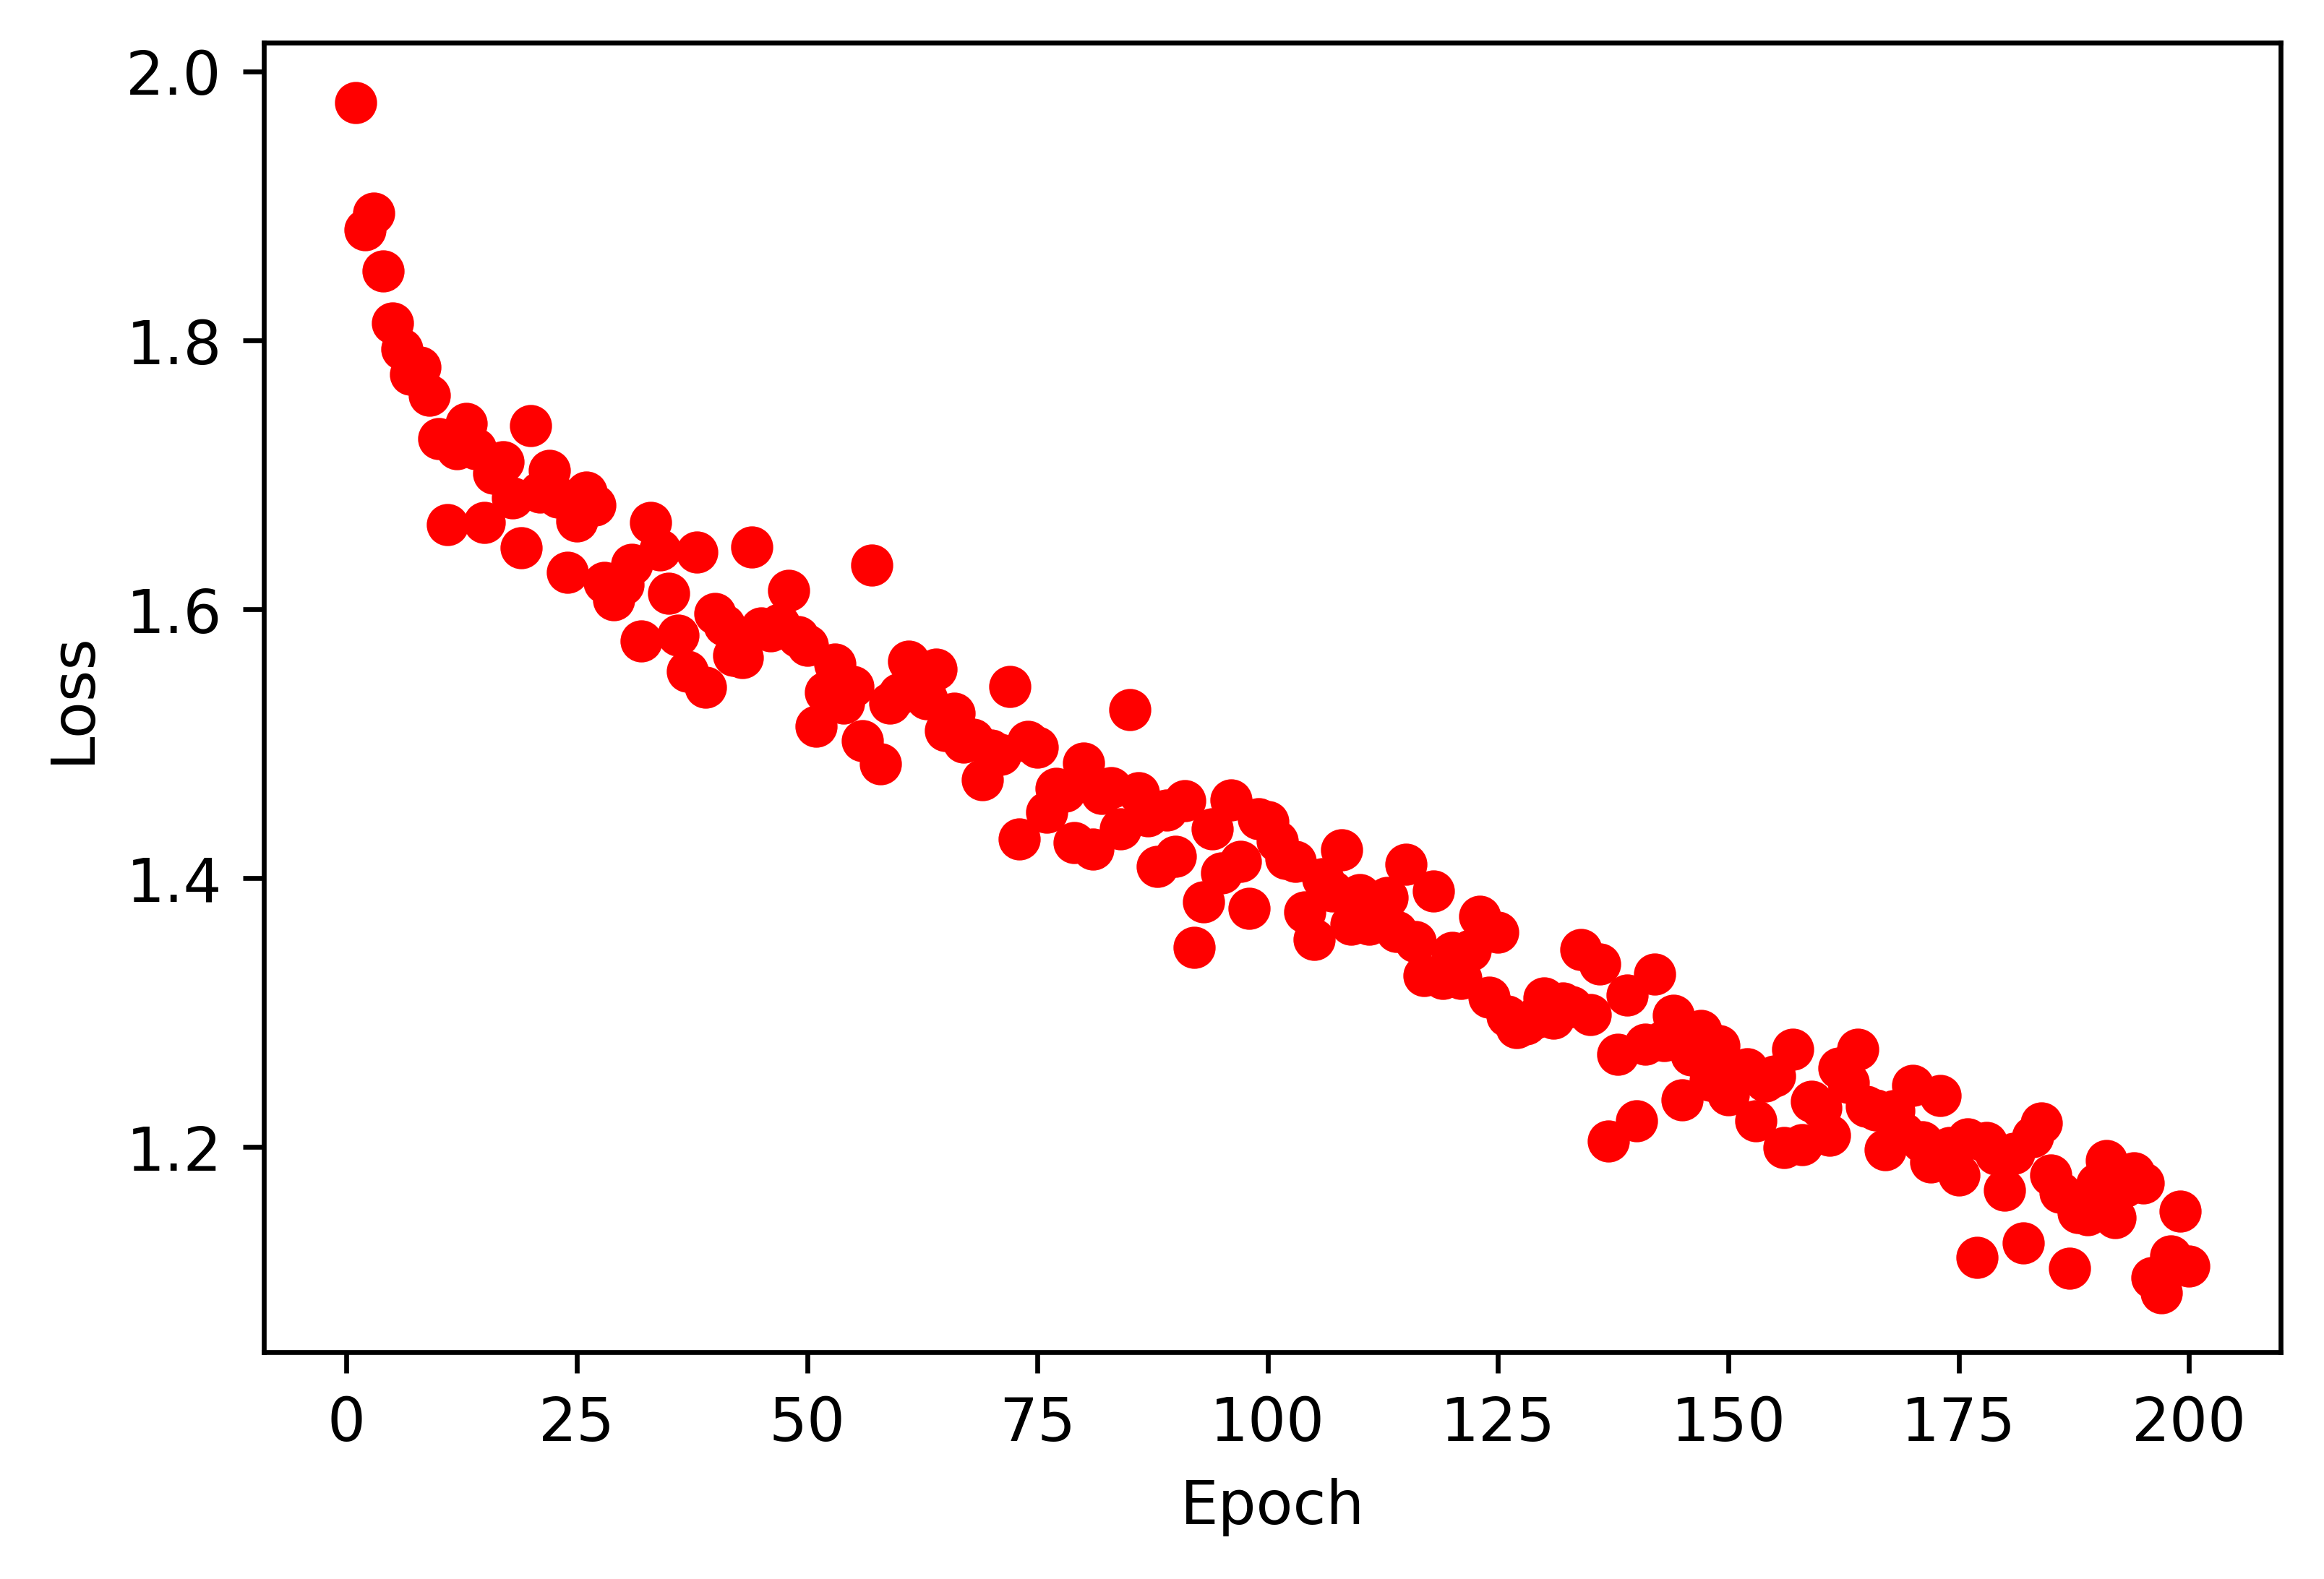

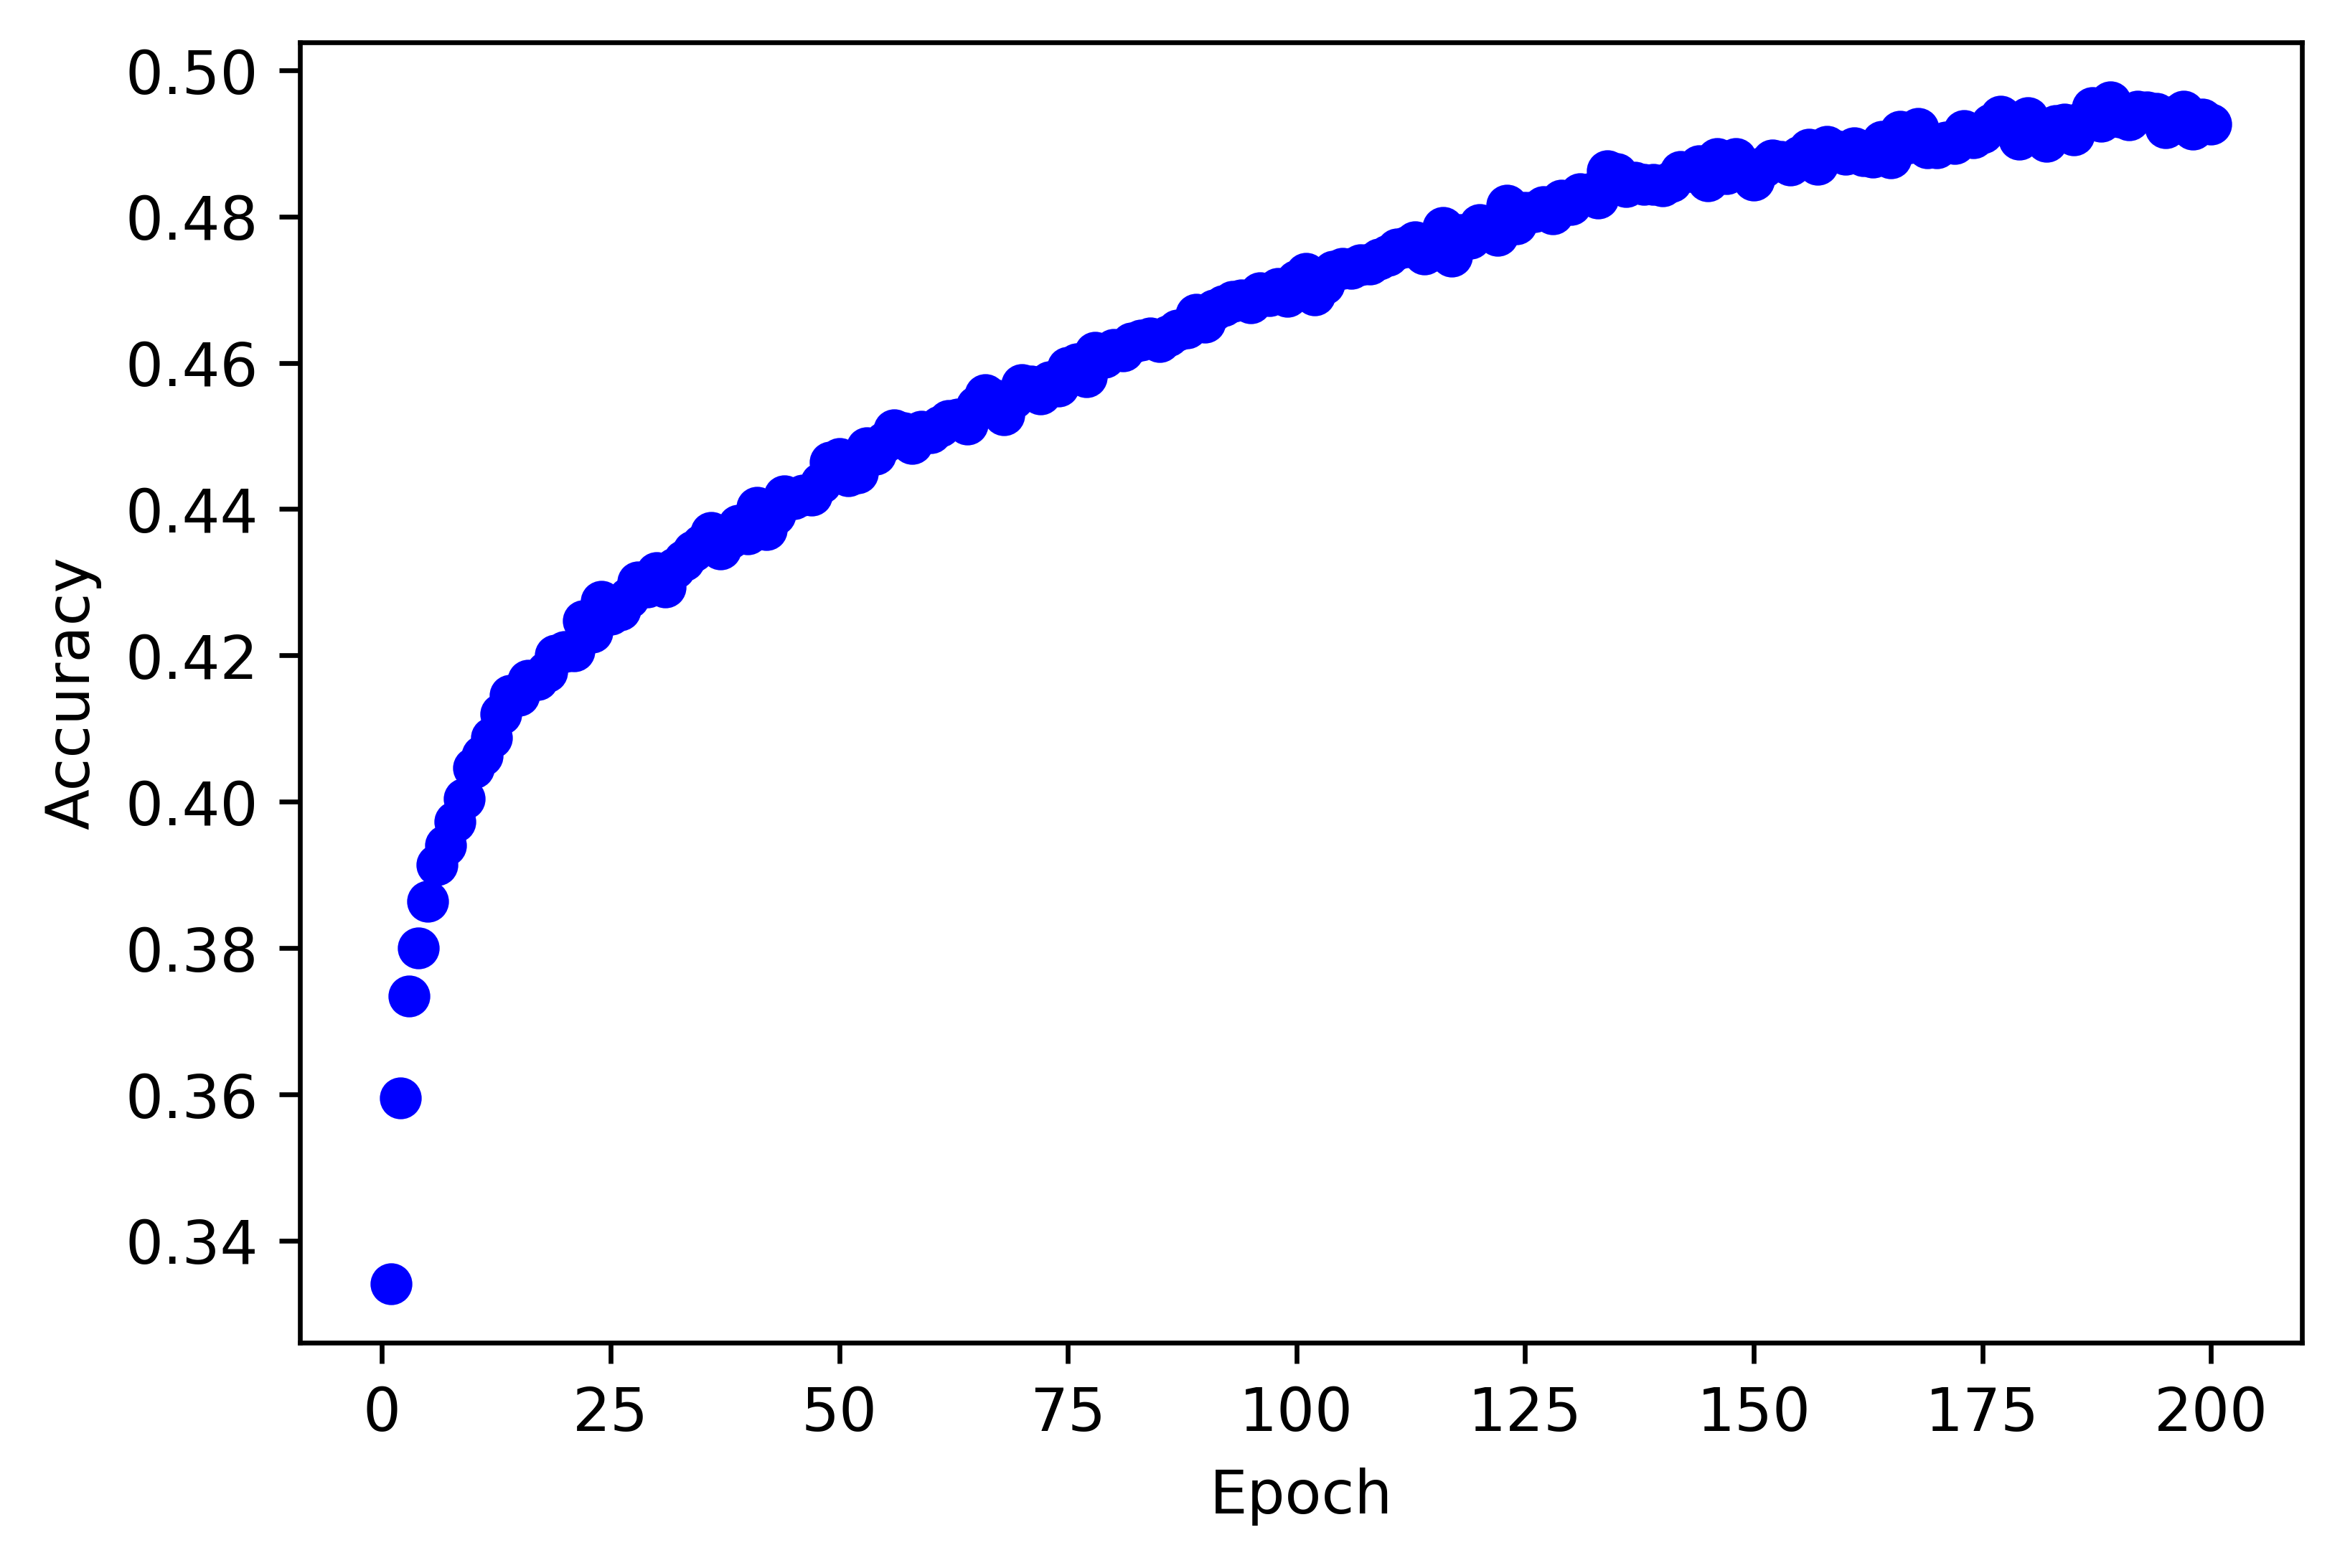

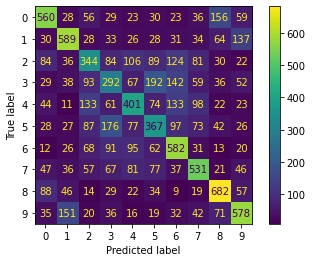

In [15]:
modelC = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,10),
    nn.LogSoftmax(dim=1)
).to(device)

learning_rate = 1e-2

optimizer = optim.SGD(modelC.parameters(),lr=learning_rate)

loss_fn = nn.NLLLoss().to(device)

n_epochs = 200

training_loop(
    n_epochs=n_epochs, 
    optimizer=optimizer, 
    model=modelC, 
    loss_fn=loss_fn, 
    train_load=train_loader, 
    val_load=val_loader
)

gt_array = []
pred_array = []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        batch_size = imgs.shape[0]
        outputs = modelC(imgs.view(batch_size,-1))
        _, predicted = torch.max(outputs,dim=1)
        gt_array.append(labels)
        pred_array.append(predicted)
        
gt_array = torch.concat(gt_array)
pred_array = torch.concat(pred_array)
ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()

### Part 2

Epoch 10, Train Loss: 1.835418, Val Accuracy: 0.359300
Epoch 20, Train Loss: 1.781455, Val Accuracy: 0.389400
Epoch 30, Train Loss: 1.729753, Val Accuracy: 0.407400
Epoch 40, Train Loss: 1.625753, Val Accuracy: 0.420200
Epoch 50, Train Loss: 1.637026, Val Accuracy: 0.431200
Epoch 60, Train Loss: 1.581051, Val Accuracy: 0.441800
Epoch 70, Train Loss: 1.533412, Val Accuracy: 0.446800
Epoch 80, Train Loss: 1.483232, Val Accuracy: 0.457000
Epoch 90, Train Loss: 1.392807, Val Accuracy: 0.465100
Epoch 100, Train Loss: 1.391321, Val Accuracy: 0.470600
Epoch 110, Train Loss: 1.315632, Val Accuracy: 0.478100
Epoch 120, Train Loss: 1.397245, Val Accuracy: 0.475800
Epoch 130, Train Loss: 1.312929, Val Accuracy: 0.480700
Epoch 140, Train Loss: 1.343461, Val Accuracy: 0.467700
Epoch 150, Train Loss: 1.197175, Val Accuracy: 0.488600
Epoch 160, Train Loss: 1.253503, Val Accuracy: 0.440400
Epoch 170, Train Loss: 1.047514, Val Accuracy: 0.491200
Epoch 180, Train Loss: 1.072170, Val Accuracy: 0.477600
E

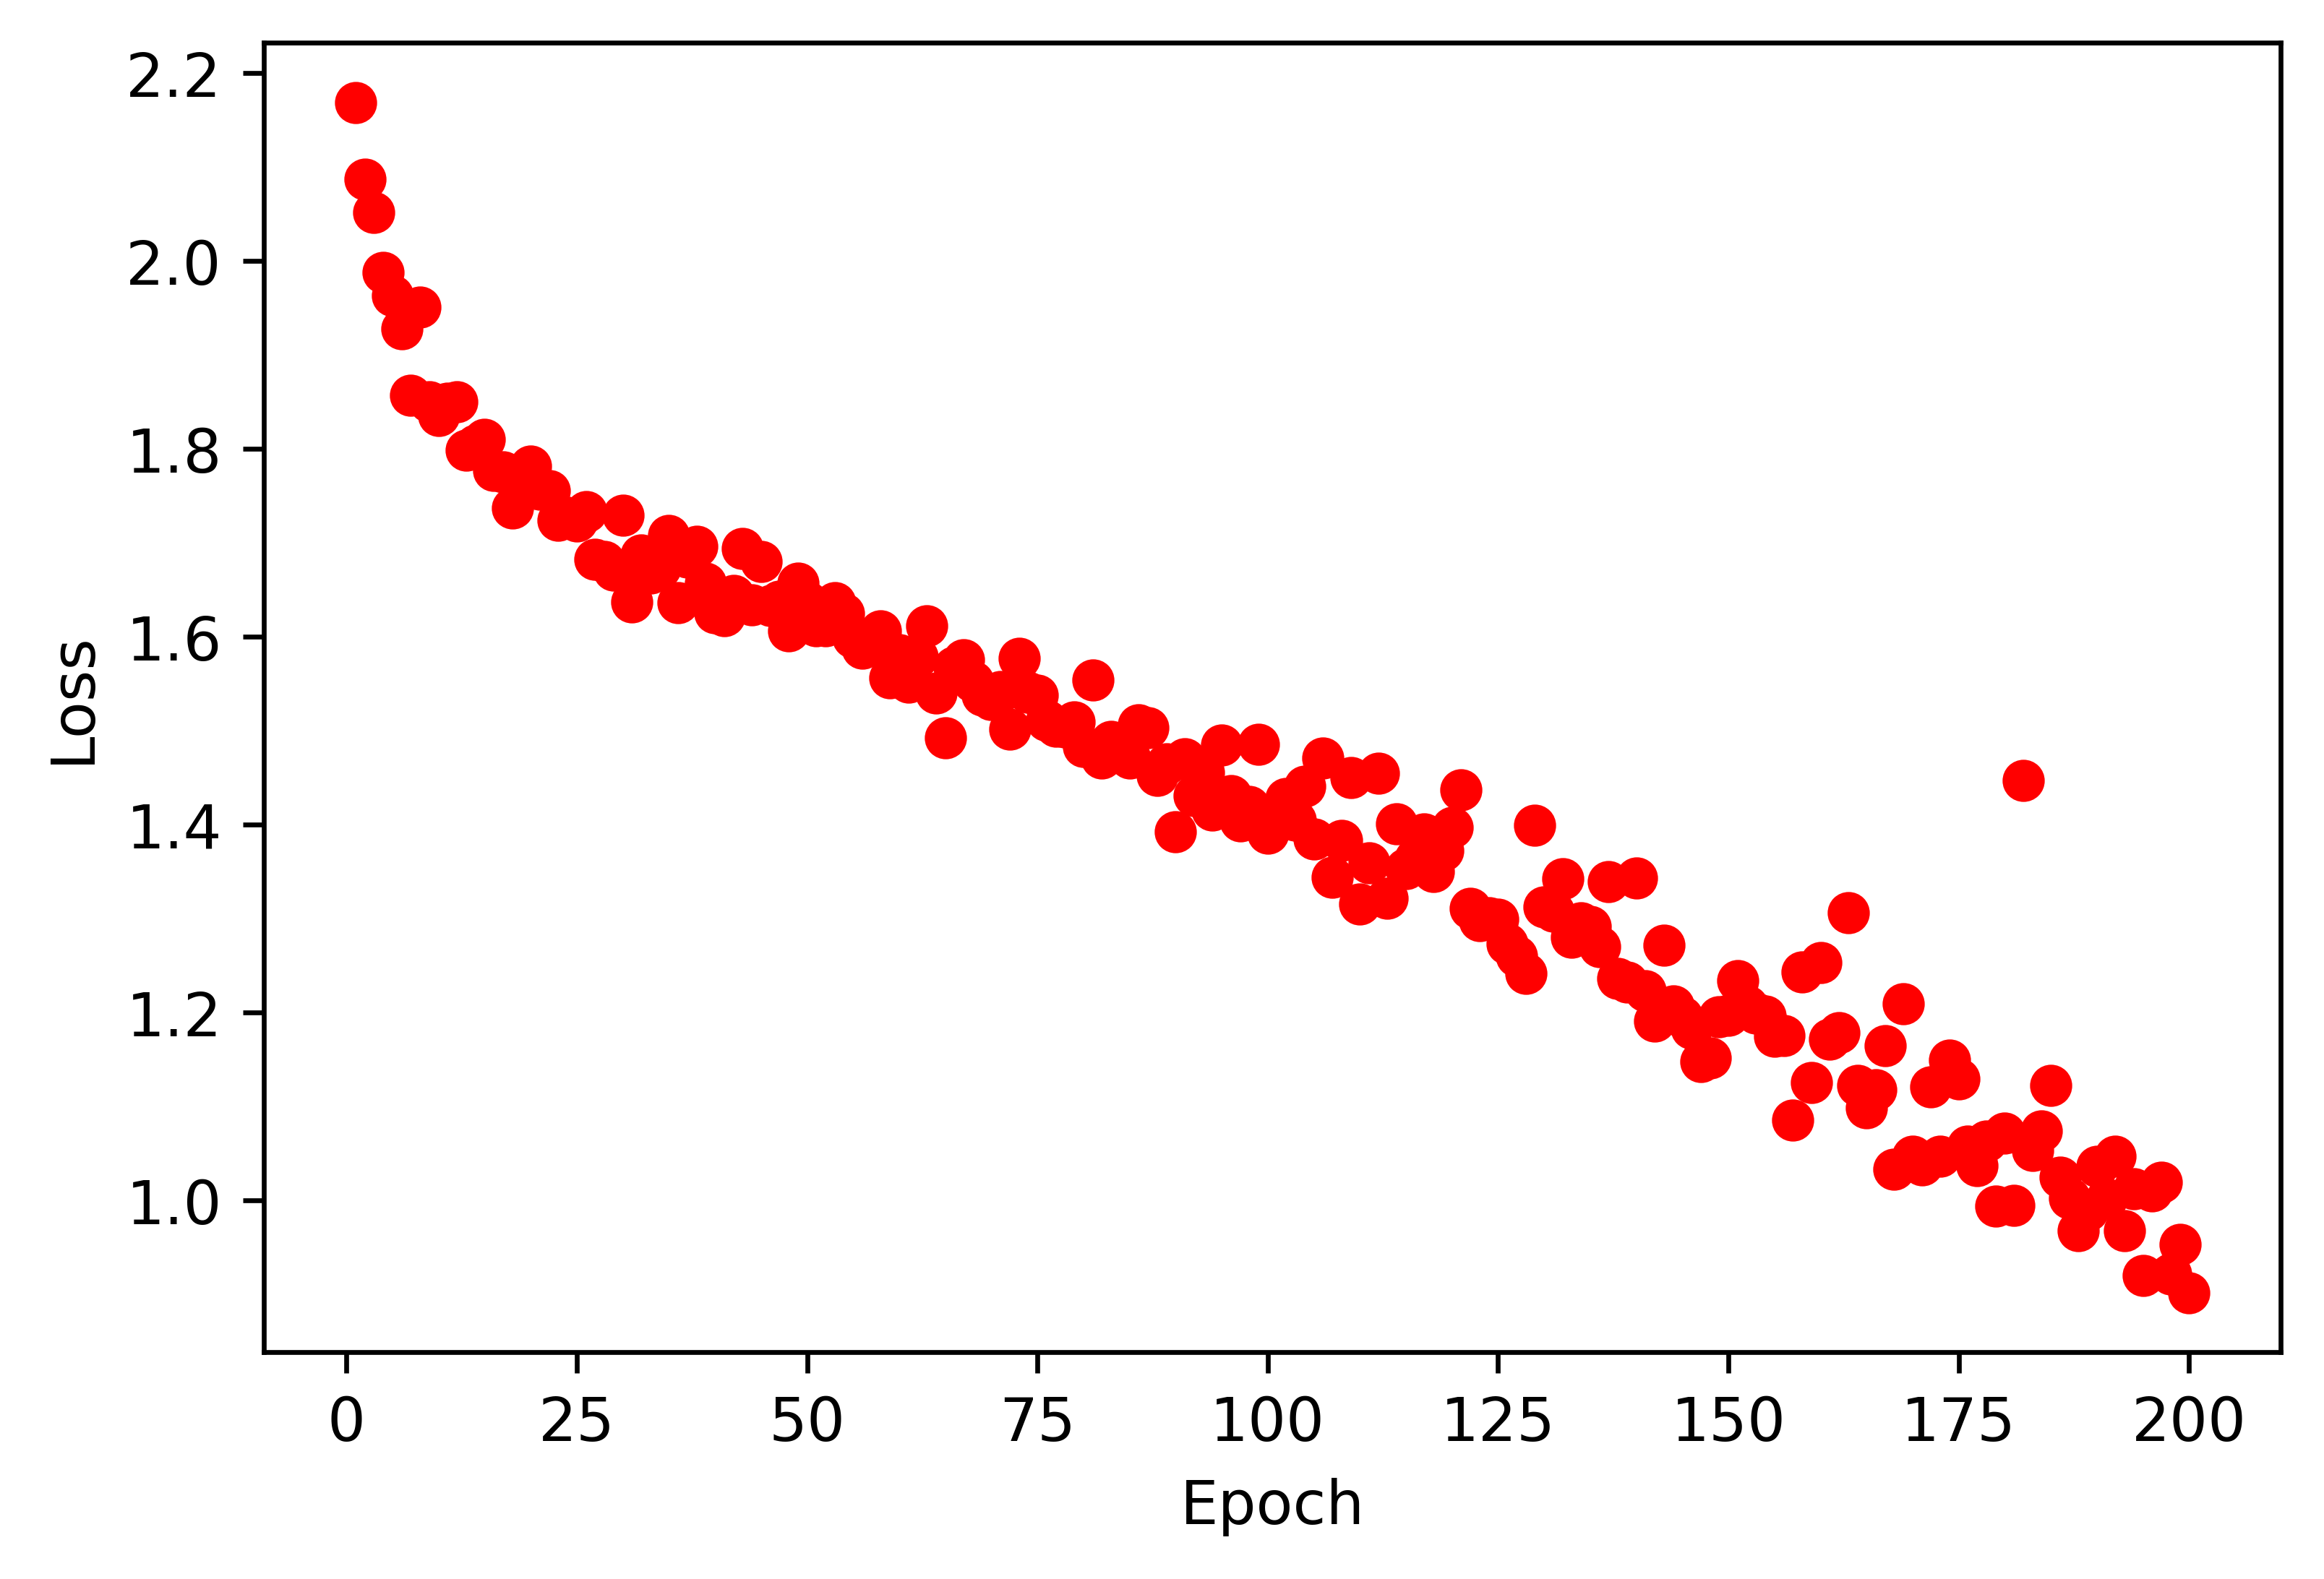

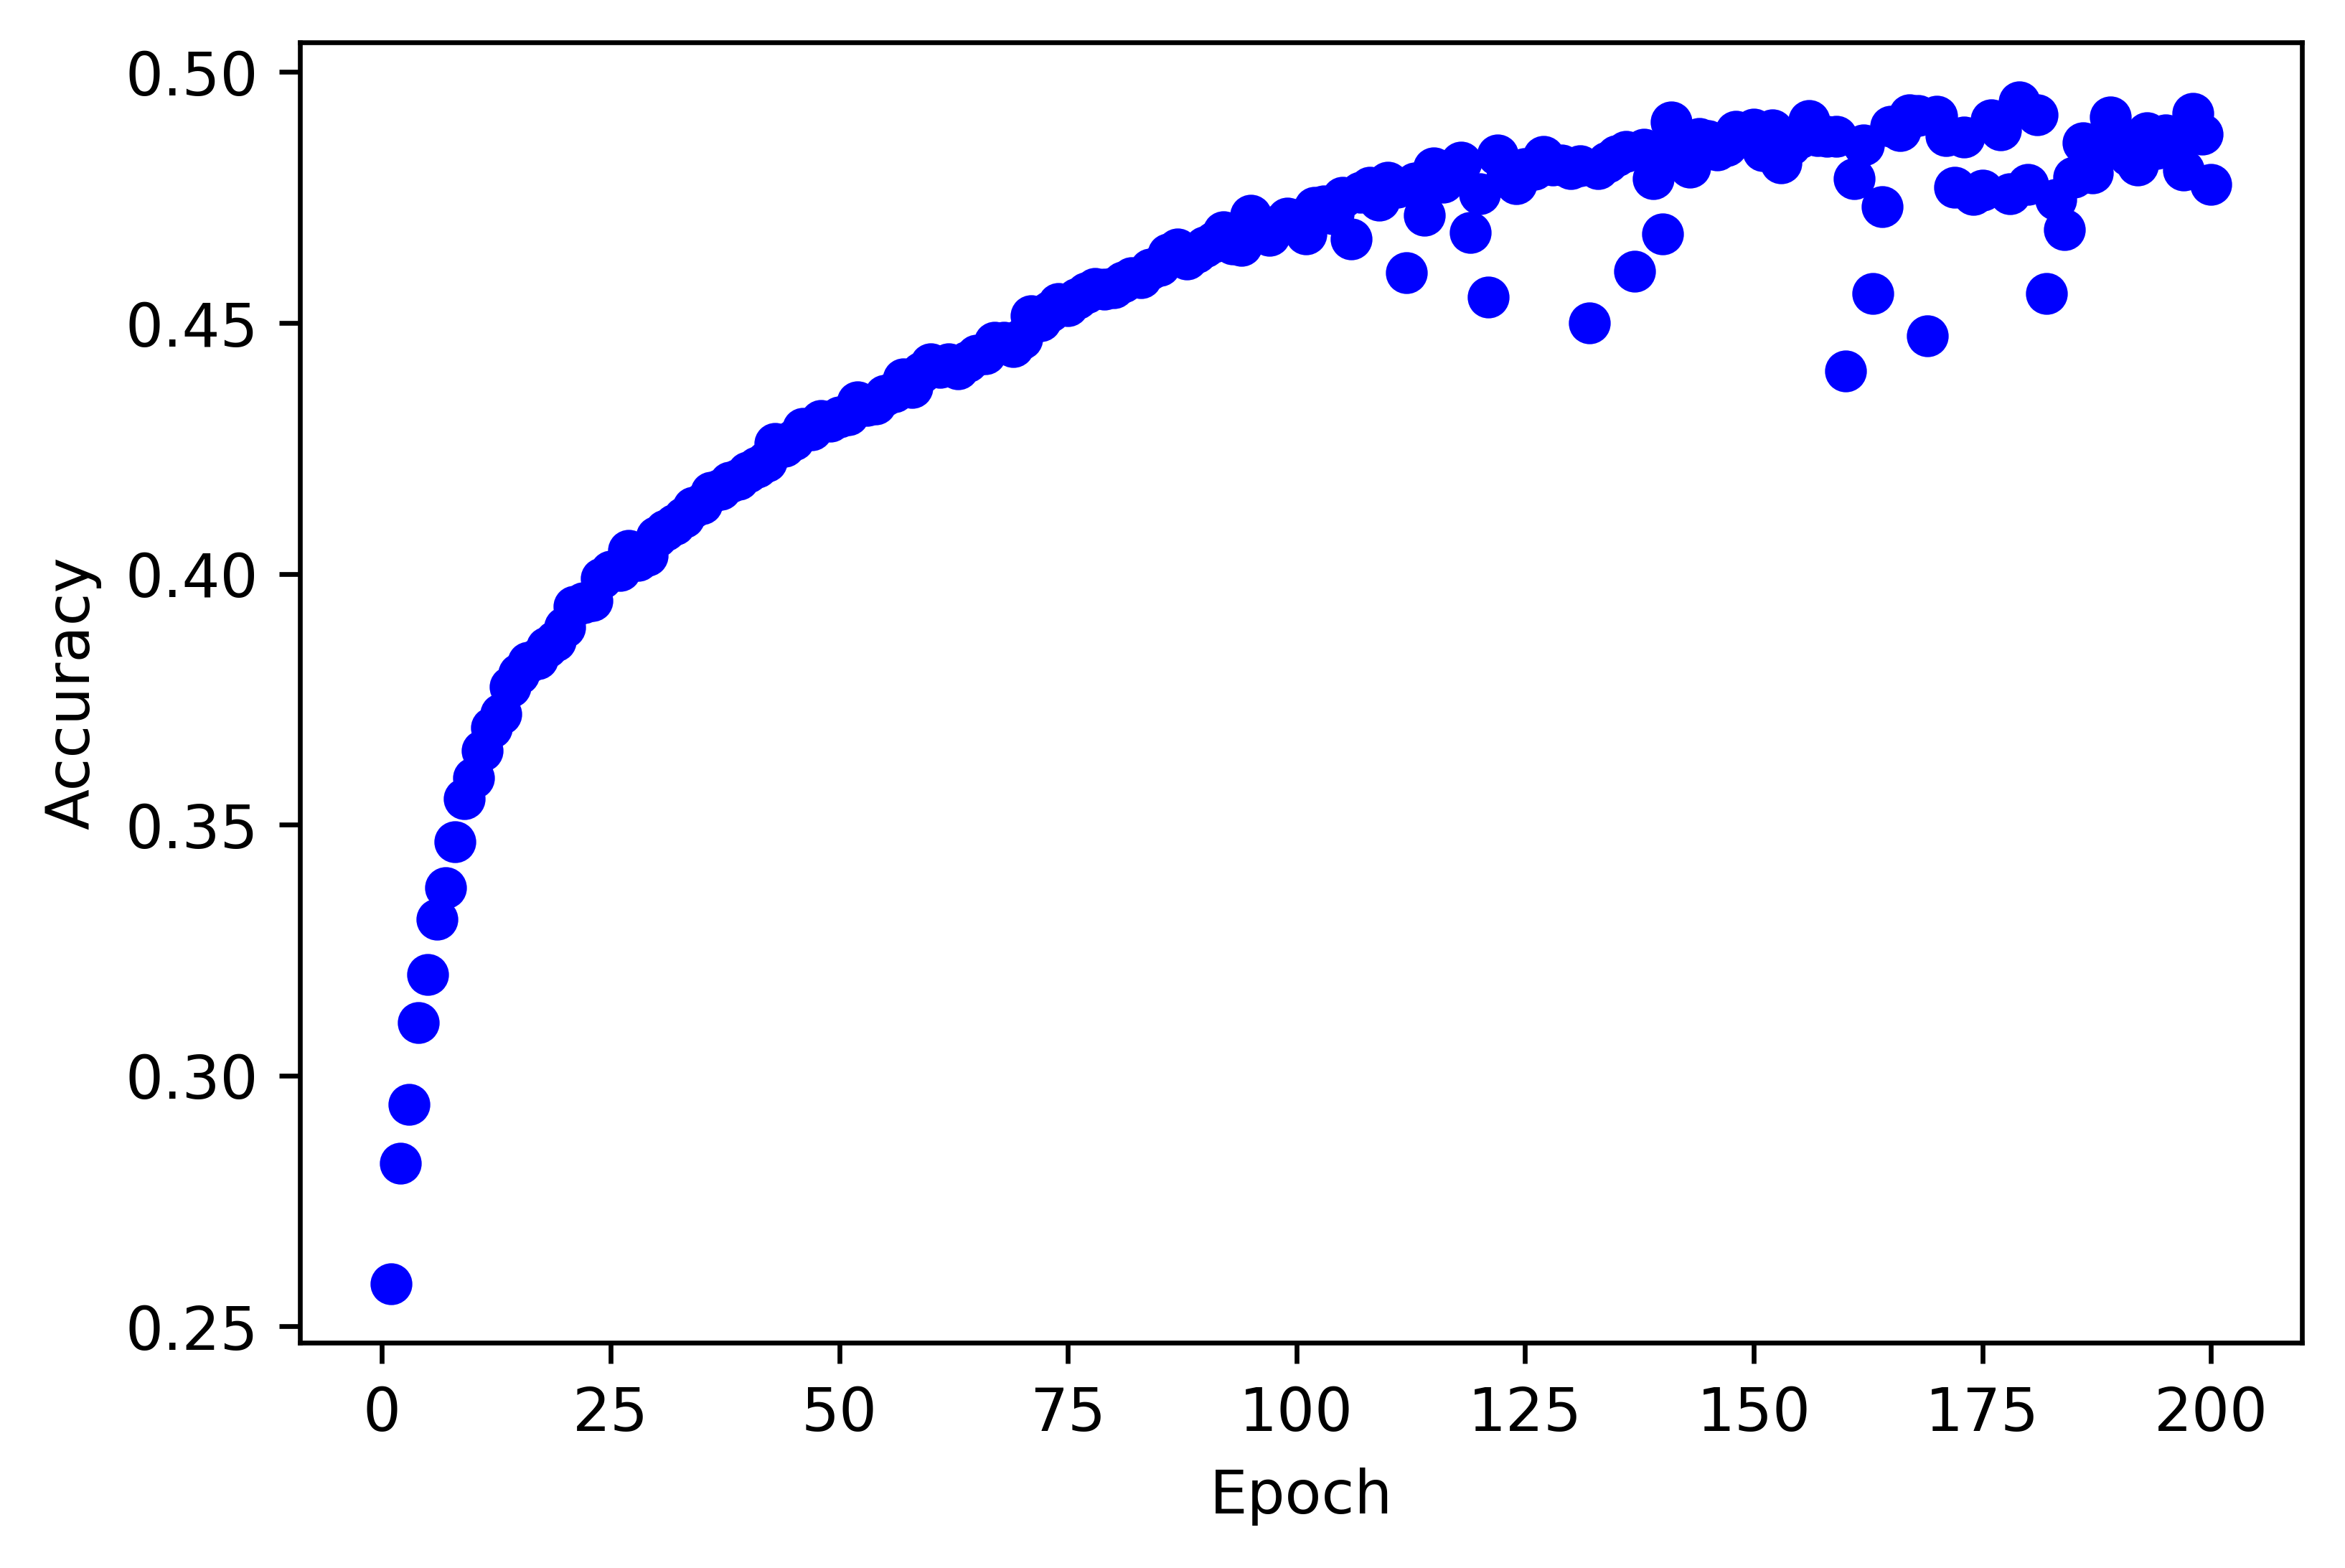

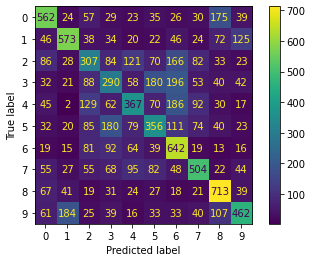

In [16]:
modelC2 = nn.Sequential(
    nn.Linear(3072,512),
    nn.Tanh(),
    nn.Linear(512,256),
    nn.Tanh(),
    nn.Linear(256,128),
    nn.Tanh(),
    nn.Linear(128,10),
    nn.LogSoftmax(dim=1)
).to(device)

learning_rate = 1e-2

optimizer2 = optim.SGD(modelC2.parameters(),lr=learning_rate)

loss_fn = nn.NLLLoss().to(device)

n_epochs = 200

training_loop(
    n_epochs=n_epochs, 
    optimizer=optimizer2, 
    model=modelC2, 
    loss_fn=loss_fn, 
    train_load=train_loader, 
    val_load=val_loader
)

gt_array = []
pred_array = []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        batch_size = imgs.shape[0]
        outputs = modelC2(imgs.view(batch_size,-1))
        _, predicted = torch.max(outputs,dim=1)
        gt_array.append(labels)
        pred_array.append(predicted)
        
gt_array = torch.concat(gt_array)
pred_array = torch.concat(pred_array)
ConfusionMatrixDisplay(confusion_matrix(gt_array.to('cpu'),pred_array.to('cpu'))).plot()